<a href="https://colab.research.google.com/github/telemetry-racing/gt7-torque-calculation/blob/main/Torque_Calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instuctions**
First run the setup. After you see the message **Setup complete** you can run input parameters with block as many times as you like. On the left side you will see files and after you click on it. You will see the files in colab, and there you can upload your screenshot with kgfm and BHP diagrams. After you add proper name for a file you need to ajust gear rations. And tire diameter.

If you have any issues create one
[here](https://github.com/telemetry-racing/gt7-torque-calculation/issues)

Screenshot is a file name that you uploaded here in colab.

Other values shall be copied from gear adjustments. And if your car does not have all 8 gears then just put 0 to all other values.

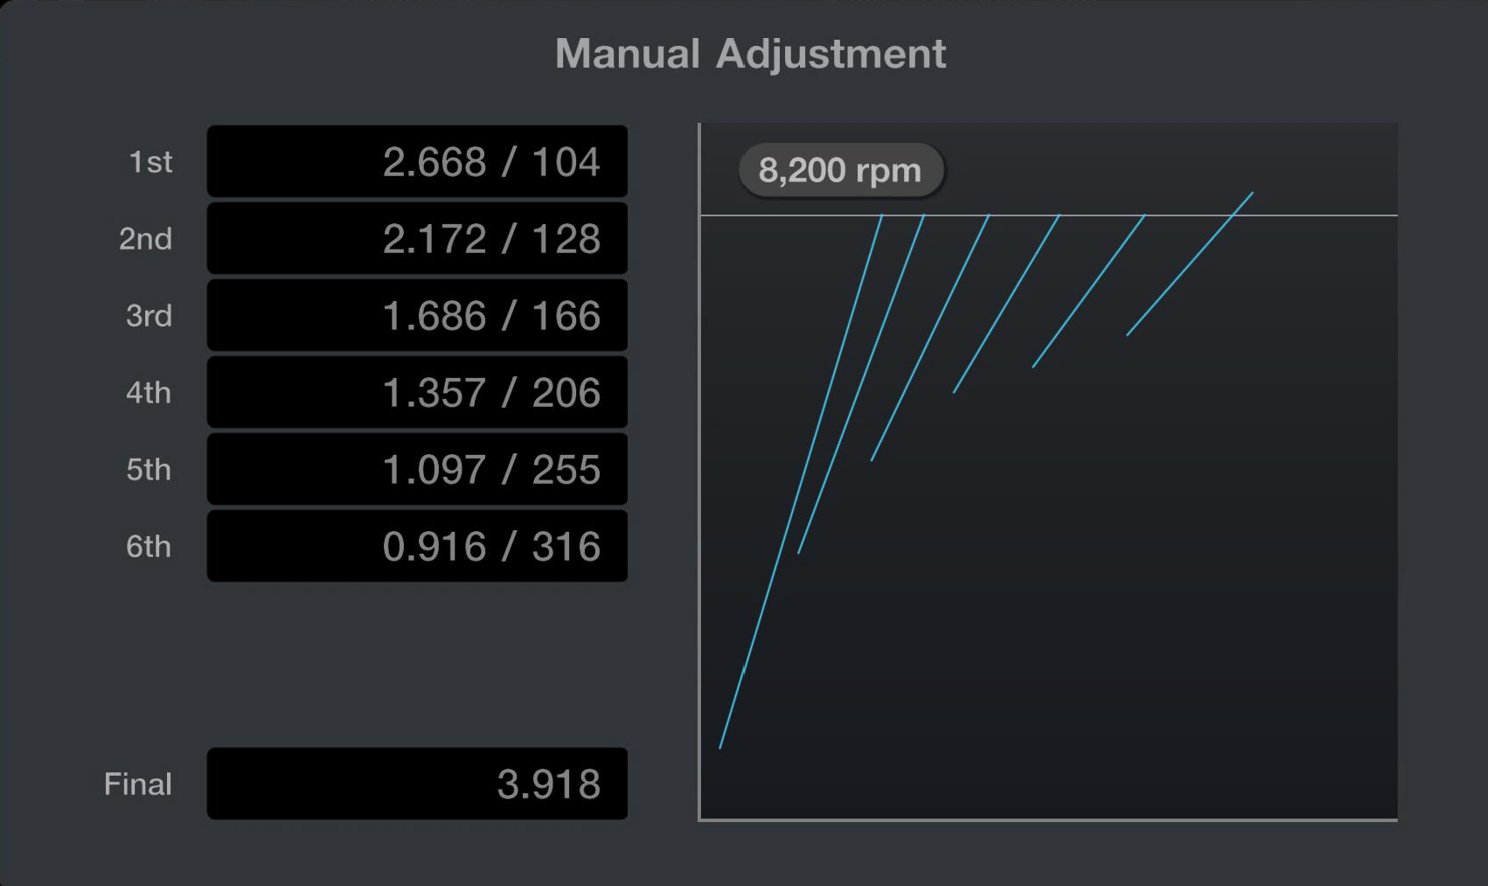


In [ ]:
# @title Setup
!rm -rf /content/torque-calculation
!git clone https://github.com/telemetry-racing/gt7-torque-calculation.git  > /dev/null 2>&1
# !sudo add-apt-repository -y ppa:alex-p/tesseract-ocr5 > /dev/null 2>&1
# !sudo apt update  > /dev/null 2>&1
# !sudo apt install tesseract-ocr > /dev/null 2>&1
# !pip install pytesseract > /dev/null 2>&1
!pip install easyocr > /dev/null 2>&1


import cv2
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
#import pytesseract
import easyocr
from operator import itemgetter
%matplotlib inline

diagram = cv2.imread("torque-calculation/diagram.jpg")
reader = easyocr.Reader(['en'])

# @title Processing Functions

# def extract_text(image):
#     gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     denoised_image = cv2.fastNlMeansDenoising(gray_image, None, 10, 7, 21)
#     return pytesseract.image_to_string(denoised_image)

def extract_text(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    denoised_image = cv2.fastNlMeansDenoising(gray_image, None, 10, 7, 21)
    result = reader.readtext(denoised_image)

    text_list = [ t[1] for t in result]
    return " ".join(text_list)

def extract_diagram_image(image, diagram):
    match_result = cv2.matchTemplate(image, diagram, cv2.TM_CCOEFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(match_result)
    h = max_loc[1]
    w = max_loc[0]
    matched_diagram = image[h:h+diagram.shape[0],w:w+diagram.shape[1],:]
    return matched_diagram

# def extract_numbers(image):
#     def extract_digits(text):
#         return ''.join(c for c in text if c.isdigit())

#     text = extract_text(image).split("\n")
#     text = [line for line in text if len(extract_digits(line))>0]
#     bph_max = int(extract_digits(text[0]))
#     kgfm_max = int(extract_digits(text[1]))
#     rpm_text = [line for line in text if "rpm" in line][0]
#     rpm_split = rpm_text.split("rpm")
#     rpm_min = int(extract_digits(rpm_split[0]))
#     rpm_max = int(extract_digits(rpm_split[1]))
#     return rpm_min, rpm_max, kgfm_max, bph_max

def extract_numbers(image, reader):
    def extract_digits(text):
        return ''.join(c for c in text if c.isdigit())

    ocr_result = reader.readtext(image)

    image_shape = image.shape
    kgfm = None
    bhp = None
    rpm_min = None
    rpm_max = None

    for bbox, text, prob in ocr_result:
        if prob < 0.75:
            continue

        text = extract_digits(text)
        if len(text) == 0:
            continue

        x = bbox[0][0] / image_shape[1]
        y = bbox[0][1] / image_shape[0]

        if x < 0.5 and y < 0.5:
            kgfm = int(text)
        elif x > 0.5 and y < 0.5:
            bhp = int(text)
        elif x < 0.5 and y > 0.5:
            rpm_min = int(text)
        elif x > 0.5 and y > 0.5:
            rpm_max = int(text)

    return rpm_min, rpm_max, kgfm, bhp


def extract_car_name(image):
    ratio = image.shape[0]/2160
    h_min = int(420 * ratio)
    h_max = int(500 * ratio)
    w_max = int(900 * ratio)
    return extract_text(image[h_min:h_max,:w_max,:]).strip()


def find_coordinates(gray_diagram, colour_diagram):
    def is_cyan(pixel):
        return pixel[0] / pixel[2] >= 1.3 and pixel[1] / pixel[2] >= 1.3

    def is_bhp_region(region, x, ymin, colour_diagram):
        for y in range(region[0],region[1]+1):
            if is_cyan(colour_diagram[y+ymin,x]):
                return True
        return False

    def find_regions(slice):
        result = []
        in_region = False
        region_start = 0
        for i in range(len(slice)):
            if in_region:
                if not slice[i]:
                    in_region = False
                    result.append((region_start,i-1))
            else:
                if slice[i]:
                    region_start = i
                    in_region = True
        if in_region:
            result.append((region_start,len(slice)-1))
        return result
    kgfm_x = []
    kgfm_y = []

    bhp_x = []
    bhp_y = []

    working_diagram = gray_diagram > 100
    xaxis = np.count_nonzero(gray_diagram > 60,axis=0) > gray_diagram.shape[0] * 0.5
    #find where X axis begin in image
    for i in range(len(xaxis)//2):
        if xaxis[i]:
            xmin = i
            break

    #find where X axis ends in the image
    for i in range(len(xaxis)//2,len(xaxis)):
        if xaxis[i]:
            xmax = i

    #find where is Y start
    yaxis = np.count_nonzero(working_diagram,axis=1) > gray_diagram.shape[1] * 0.5
    for i in range(len(yaxis)):
        if yaxis[i]:
            ymax = i
            break

    #find where diagram start on Y axis
    yaxis = np.count_nonzero(gray_diagram < 45,axis=1) > gray_diagram.shape[1] * 0.5
    for i in range(len(yaxis)):
        if yaxis[i]:
            ymin = i
            break
    #print(xmin,xmax,ymin,ymax)

    for x in range(xmin, xmax+1):
        found_kgfm = None
        found_bhp = None
        regions = find_regions(working_diagram[ymin:ymax,x])
        if len(regions) >= 3:
            regions = regions[-2:]
        if len(regions) == 2:
            for region in regions:
                if is_bhp_region(region, x, ymin, colour_diagram):
                    found_bhp = region
                else:
                    found_kgfm = region
        else:
            found_kgfm = region

        if found_bhp is not None:
            bhp_x.append(x)
            bhp_y.append(ymax - found_bhp[0])
        if found_kgfm is not None:
            kgfm_x.append(x)
            kgfm_y.append(ymax - found_kgfm[0])

    return pd.Series(data=kgfm_y, index= kgfm_x) , pd.Series(data=bhp_y, index= bhp_x)

def normalize_values(values, rpm_min, rpm_max, y_out_max):
    rpm_in_min = values.index[0]
    rpm_in_max = values.index[-1]
    new_index = np.interp(values.index,[rpm_in_min,rpm_in_max], [rpm_min, rpm_max])
    new_values = np.interp(values.values, [0, values.max()], [0, y_out_max])
    return pd.Series(data=new_values, index= new_index)

def calculate_wheel_speed(torque, gears, gear_names, final_ratio, tire_diameter_in_meters):
    rpms = torque.index
    #gear_names = [x+'_ws' for x in gear_names]
    base_gear_ratio = rpms * ((math.pi * tire_diameter_in_meters * 0.06) / final_ratio) # Calculate base gear ratio for each RPM
    gear_list = []
    for i in range(len(gears)):
        if gears[i] != 0:
            # Calculate wheel speed for each gear and all RPMs
            gear_speed = base_gear_ratio / gears[i]
            gear_list.append(gear_speed)
        else:
            # Handle cases where gear ratio is 0
            gear_list.append(np.zeros_like(base_gear_ratio))

    # Transpose the gear_list to have gears as columns and RPMs as index
    return pd.DataFrame(np.array(gear_list).T, columns=gear_names, index=rpms)

def calculate_tractive_force(torque, gears, gear_names, final_ratio, tire_diameter_in_meters):

    base_torque = torque * (2 * final_ratio / tire_diameter_in_meters)
    rpms = torque.index
    #gear_names = [x+'_tf' for x in gear_names]
    torque_list = []
    for i in range(len(gears)):
        gear_torque = base_torque * gears[i]
        torque_list.append(gear_torque)
    # Transpose the torque_list to have gears as columns and RPMs as index
    return pd.DataFrame(np.array(torque_list).T, columns=gear_names, index=rpms)

def rpm_gear_name(name):
    return 'rpm_' + name

def diff_gear_name(name):
    return 'diff_' + name

def index_by_speed(df_wheel_speed, df_traction_force):
    # Create a new index from minimum speed to max speed with a step of 0.1
    new_index = np.arange(0, df_wheel_speed.max().max() + 0.1, 0.1)
    gears = df_traction_force.columns

    # Create a new DataFrame with the new index
    speed_rpm = pd.DataFrame(index=new_index)

    # Interpolate the values from wheel_speed for each gear
    for gear in df_wheel_speed.columns:
        speed_rpm[gear] = np.interp(new_index, df_wheel_speed[gear], df_wheel_speed.index, right=np.nan)

    speed_tractions = pd.DataFrame(index=new_index)
    for gear in df_traction_force.columns:
        speed_tractions[gear] = np.interp(speed_rpm[gear],df_traction_force.index, df_traction_force[gear], right=np.nan)
        speed_tractions[rpm_gear_name(gear)] = speed_rpm[gear]

    for i in range(len(gears)-1):
        speed_tractions[diff_gear_name(gears[i])] = (speed_tractions[gears[i]] - speed_tractions[gears[i+1]]).abs().replace(0.0,np.nan)


    return speed_tractions

def calculate_wheel_diameter(rpm, gear_ratio, gear_max_speed, final_ratio):
    diameters = []
    for i in range(len(gear_ratio)):
      diameters.append((gear_ratio[i] * gear_max_speed[i] * final_ratio) / (0.06 * math.pi * rpm))
    return max(diameters)

def create_output(wheel_speed, speed_traction, gear_names):
    min_graph_speed = int(wheel_speed.replace(0,np.nan).min().min()*10)
    magic = speed_traction.iloc[min_graph_speed:]

    current_gears = []
    next_gear = []
    speed_kmph = []
    speed_mph = []
    rpms = []

    spaces = []
    space = ' '
    for i in range(len(gear_names)-1):
        gear = gear_names[i]
        if len(magic[diff_gear_name(gear)].dropna()) == 0:
            break
        speed = magic[diff_gear_name(gear)].idxmin(skipna=True)
        rpm = magic.loc[speed,rpm_gear_name(gear)]
        current_gears.append(gear)
        next_gear.append(gear_names[i+1])
        speed_kmph.append(round(speed))
        speed_mph.append(round(speed * 0.6213712))
        rpms.append(round(rpm))
        spaces.append(space*i)


    return pd.DataFrame({'Speed kilometers':speed_kmph,
                         'Speed miles': speed_mph,
                         'RPM' : rpms,
                         'Gear from': current_gears,
                         'Gear to' : next_gear}, index=spaces)


def create_output_json(wheel_speed, speed_traction, gear_names):
    min_graph_speed = int(wheel_speed.replace(0,np.nan).min().min()*10)
    magic = speed_traction.iloc[min_graph_speed:]

    current_gears = []
    next_gear = []
    speed_kmph = []
    speed_mph = []
    rpms = []

    spaces = []
    space = ' '
    for i in range(len(gear_names)-1):
        gear = gear_names[i]
        if len(magic[diff_gear_name(gear)].dropna()) == 0:
            break
        speed = magic[diff_gear_name(gear)].idxmin(skipna=True)
        rpm = magic.loc[speed,rpm_gear_name(gear)]
        current_gears.append(gear)
        next_gear.append(gear_names[i+1])
        speed_kmph.append(round(speed))
        speed_mph.append(round(speed * 0.6213712))
        rpms.append(round(rpm))
        spaces.append(space*i)


    return pd.DataFrame({'Speed kilometers':speed_kmph,
                         'Speed miles': speed_mph,
                         'RPM' : rpms,
                         'Gear from': current_gears,
                         'Gear to' : next_gear}, index=current_gears)

print("Setup complete")

In [ ]:
# @title Input parameters
screenshot = 'torque-calculation/sample-screenshot.jpg' # @param {type:"string"}

gear_1 = 2.668 # @param {type:"number"}
gear_1_max_speed = 104 # @param {type:"integer"}
gear_2 = 2.172 # @param {type:"number"}
gear_2_max_speed = 128 # @param {type:"integer"}
gear_3 = 1.686 # @param {type:"number"}
gear_3_max_speed = 166 # @param {type:"integer"}
gear_4 = 1.357 # @param {type:"number"}
gear_4_max_speed = 206 # @param {type:"integer"}
gear_5 = 1.097 # @param {type:"number"}
gear_5_max_speed = 255 # @param {type:"integer"}
gear_6 = 0.916 # @param {type:"number"}
gear_6_max_speed = 316 # @param {type:"integer"}
gear_7 = 0 # @param {type:"number"}
gear_7_max_speed = 0 # @param {type:"integer"}
gear_8 = 0 # @param {type:"number"}
gear_8_max_speed = 0 # @param {type:"integer"}
gears = [gear_1, gear_2, gear_3, gear_4, gear_5, gear_6, gear_7, gear_8]
gears_max_speed = [gear_1_max_speed,
                   gear_2_max_speed,
                   gear_3_max_speed,
                   gear_4_max_speed,
                   gear_5_max_speed,
                   gear_6_max_speed,
                   gear_7_max_speed,
                   gear_8_max_speed]
gear_names = ['1st Gear','2nd Gear','3rd Gear','4th Gear','5th Gear','6th Gear','7th_Gear','8th_Gear']

final_ratio = 3.918 # @param {type:"number"}

img = cv2.imread(screenshot,cv2.IMREAD_COLOR)
assert img is not None, "Screenshot filename is not correct"
print(extract_car_name(img))

matched_diagram = extract_diagram_image(img, diagram)
gray_matched_diagram = cv2.cvtColor(matched_diagram, cv2.COLOR_BGR2GRAY)
kgfm, bhp = find_coordinates(gray_matched_diagram,matched_diagram)
rpm_min, rpm_max, kgfm_max, bhp_max = extract_numbers(matched_diagram, reader)
print(f"rpm_min = {rpm_min}")
print(f"rpm_max = {rpm_max}")
print(f"kgfm_max = {kgfm_max}")
print(f"bhp_max = {bhp_max}")
normalized_kgfm = pd.concat([pd.Series({0: 0}), normalize_values(kgfm, rpm_min, rpm_max, kgfm_max)])
normalized_bhp = normalize_values(bhp, rpm_min, rpm_max, bhp_max)

tire_diameter_in_meters = calculate_wheel_diameter(rpm_max, gears, gears_max_speed, final_ratio)

tractive_force = calculate_tractive_force(normalized_kgfm, gears, gear_names, final_ratio, tire_diameter_in_meters)
wheel_speed = calculate_wheel_speed(normalized_kgfm, gears, gear_names, final_ratio, tire_diameter_in_meters)
speed_tractions = index_by_speed(wheel_speed, tractive_force)

result = create_output(wheel_speed, speed_tractions, gear_names)
result.T